### Goal (Module 1: Pain-Adjusted Screen)
We want to select ETF components for a Defensive Growth portfolio by ranking ETFs on efficiency (return per unit of pain), not return alone.

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../processed/etf_returns.csv', parse_dates=['Date'])

# Keep only what we need 
df = df[['Date', 'Ticker', 'Daily_Return']].dropna()

# Pivot to have tickers as columns
returns_wide = df.pivot(index='Date', columns='Ticker', values='Daily_Return').sort_index()

print("returns_wide shape:", returns_wide.shape)
print("Date Range:", returns_wide.index.min(), "to", returns_wide.index.max())
returns_wide.head()

returns_wide shape: (3093, 12)
Date Range: 2014-01-03 00:00:00 to 2026-01-30 00:00:00


Ticker,BND,GLD,IAU,SCHD,SPLV,SPY,VCN.TO,VDY.TO,VFV.TO,VTI,XIC.TO,ZAG.TO
Date,,,,,,,,,,,,
2014-01-03,0.000124,0.010932,0.010943,0.001377,0.000611,-0.000164,-0.002211,0.003350,-0.003174,-0.000210,-0.002797,0.000661
2014-01-06,0.000873,0.001760,0.000000,-0.003576,-0.003053,-0.002897,-0.004064,-0.008013,-0.001158,-0.002630,-0.004205,0.000661
2014-01-07,0.001247,-0.005690,-0.004996,0.005522,0.007349,0.006141,0.010015,0.005048,0.018256,0.006434,0.008447,0.002642
2014-01-08,-0.003238,-0.005891,-0.005021,-0.003569,-0.004255,0.000218,0.001469,-0.001339,0.001991,0.000734,0.000930,0.000659
2014-01-09,0.001875,0.002878,0.002523,0.001653,0.004273,0.000654,-0.000733,0.004695,0.005112,0.000838,0.000929,-0.000658


In [5]:
print("Date range:", returns_wide.index.min(), "to", returns_wide.index.max())
print("Shape:", returns_wide.shape)
print("\nMissing % per ticker (top 10):")
display((returns_wide.isna().mean().sort_values(ascending=False).head(10) * 100).to_frame("missing_%"))

print("\nNon-null counts (top 10):")
display(returns_wide.notna().sum().sort_values(ascending=False).head(10).to_frame("non_null_days"))

Date range: 2014-01-03 00:00:00 to 2026-01-30 00:00:00
Shape: (3093, 12)

Missing % per ticker (top 10):


,missing_%
Ticker,
VFV.TO,2.004526
XIC.TO,2.004526
VCN.TO,2.004526
VDY.TO,2.004526
ZAG.TO,2.004526
IAU,1.810540
GLD,1.810540
BND,1.810540
SCHD,1.810540



Non-null counts (top 10):


,non_null_days
Ticker,
BND,3037
GLD,3037
IAU,3037
SCHD,3037
SPLV,3037
SPY,3037
VTI,3037
VCN.TO,3031
VDY.TO,3031


In [6]:
TRADING_DAYS = 252

def annualized_return(r):
    r = r.dropna()
    growth  = (1 + r).prod()
    years = len(r) / TRADING_DAYS
    return growth ** (1 / years) - 1

In [7]:
def annualized_volatility(r):
    return r.std(ddof=0) * np.sqrt(TRADING_DAYS)

In [8]:
def sharpe_ratio(r, rf=0):
    excess = r -rf / TRADING_DAYS
    return excess.mean() / excess.std(ddof=0) * np.sqrt(TRADING_DAYS)

In [9]:
def sortino_ratio(r, mar=0.0):
    downside = r[r < mar]
    downside_dev = downside.std(ddof=0) * np.sqrt(TRADING_DAYS)
    return (r.mean() * TRADING_DAYS) / downside_dev if downside_dev != 0 else np.nan

# Why this matters (key talking point):
# Penalizes only harmful volatility
# Aligns with your Defensive Growth mandate
# Replaces “psychological” metrics with math

In [10]:
def max_drawdown(r):
    cumulative = (1 + r).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

#Why: This is the worst-case investor experience.

In [11]:
def ulcer_index(r):
     r = r.dropna()
     if len(r) < 2:
        return np.nan
     eq = (1 + r).cumprod()
     peak = eq.cummax()
     dd_pct = (eq / peak - 1) * 100.0
     return np.sqrt(np.mean(dd_pct**2))

# Why this is powerful:
# Two ETFs can have the same max drawdown
# The one that stays underwater longer is worse
# Ulcer Index captures that better than volatility

In [12]:
candidates = ["SPY","SCHD","USMV","QUAL","MOAT","VDY.TO","ZLB.TO","BND","ZAG.TO","GLD","IAU"]
candidates = [c for c in candidates if c in returns_wide.columns]

# candidates under consideration.

In [13]:
rows = []
for t in candidates:
    r = returns_wide[t].dropna()
    rows.append({
        "ETF": t,
        "Annualized Return": annualized_return(r),
        "Sharpe": sharpe_ratio(r),
        "Sortino": sortino_ratio(r),
        "Max Drawdown": max_drawdown(r),
        "Ulcer Index": ulcer_index(r),
    })

metrics_df = pd.DataFrame(rows).set_index("ETF")

# Efficiency Score = Return per unit of pain (Ulcer)
metrics_df["Efficiency Score"] = metrics_df["Annualized Return"] / metrics_df["Ulcer Index"]

ranked = metrics_df.sort_values("Efficiency Score", ascending=False)
ranked

,Annualized Return,Sharpe,Sortino,Max Drawdown,Ulcer Index,Efficiency Score
ETF,,,,,,
SCHD,0.113185,0.745962,0.940321,-0.333670,5.525437,0.020484
SPY,0.135901,0.823656,1.000341,-0.337173,6.692120,0.020308
VDY.TO,0.107323,0.729912,0.823907,-0.392112,7.612618,0.014098
IAU,0.118074,0.812973,1.122472,-0.242537,9.955536,0.011860
GLD,0.116427,0.802566,1.105003,-0.244929,10.133598,0.011489
ZAG.TO,0.024836,0.401734,0.450531,-0.180332,6.352259,0.003910
BND,0.022273,0.451369,0.565426,-0.185821,6.367632,0.003498


In [14]:
equity_list = ["SPY","SCHD","USMV","QUAL","MOAT","VDY.TO","ZLB.TO"]
hedge_bond_list = ["IAU","GLD","BND","ZAG.TO"]

equity_list = [t for t in equity_list if t in ranked.index]
hedge_bond_list = [t for t in hedge_bond_list if t in ranked.index]

top_2_equity = ranked.loc[equity_list].head(2)
top_1_hedge_bond = ranked.loc[hedge_bond_list].head(1)

print("Top 2 Equity ETFs (Pain-Adjusted):")
display(top_2_equity)

print("Top 1 Hedge/Bond ETF (Pain-Adjusted):")
display(top_1_hedge_bond)

Top 2 Equity ETFs (Pain-Adjusted):


,Annualized Return,Sharpe,Sortino,Max Drawdown,Ulcer Index,Efficiency Score
ETF,,,,,,
SPY,0.135901,0.823656,1.000341,-0.337173,6.692120,0.020308
SCHD,0.113185,0.745962,0.940321,-0.333670,5.525437,0.020484


Top 1 Hedge/Bond ETF (Pain-Adjusted):


,Annualized Return,Sharpe,Sortino,Max Drawdown,Ulcer Index,Efficiency Score
ETF,,,,,,
IAU,0.118074,0.812973,1.122472,-0.242537,9.955536,0.01186


In [15]:
equity_candidates = ["SPY", "SCHD", "USMV", "QUAL", "MOAT", "VDY.TO", "ZLB.TO"]
hedge_candidates = ["BND", "ZAG.TO", "GLD", "IAU"]

equity_candidates = [t for t in equity_candidates if t in returns_wide.columns]
hedge_candidates = [t for t in hedge_candidates if t in returns_wide.columns]

winners = ["SPY", "SCHD", "BND"]
winners = [t for t in winners if t in returns_wide.columns]

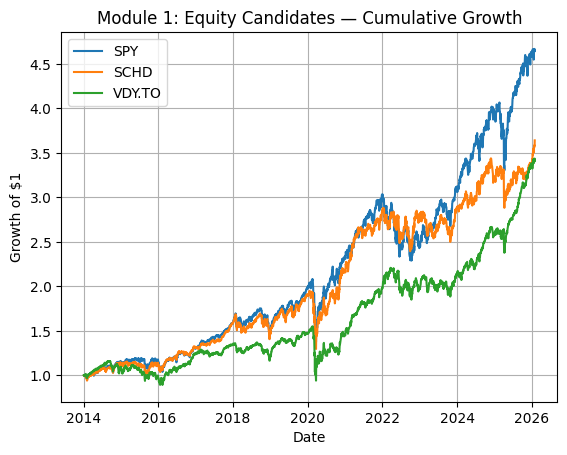

In [16]:
def equity_curve(r):
    return (1 + r.fillna(0)).cumprod()

plt.figure()
for t in equity_candidates:
    plt.plot(equity_curve(returns_wide[t]), label=t)

plt.title("Module 1: Equity Candidates — Cumulative Growth")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

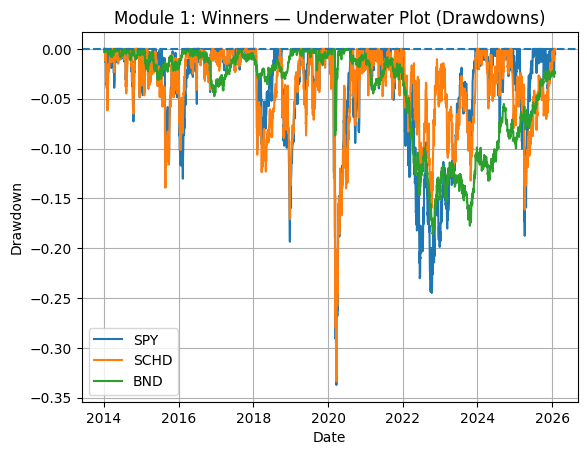

In [17]:
def drawdown_series(r):
    eq = (1 + r.fillna(0)).cumprod()
    peak = eq.cummax()
    return (eq / peak - 1)

plt.figure()
for t in winners:
    plt.plot(drawdown_series(returns_wide[t]), label=t)

plt.axhline(0, linestyle="--")
plt.title("Module 1: Winners — Underwater Plot (Drawdowns)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()


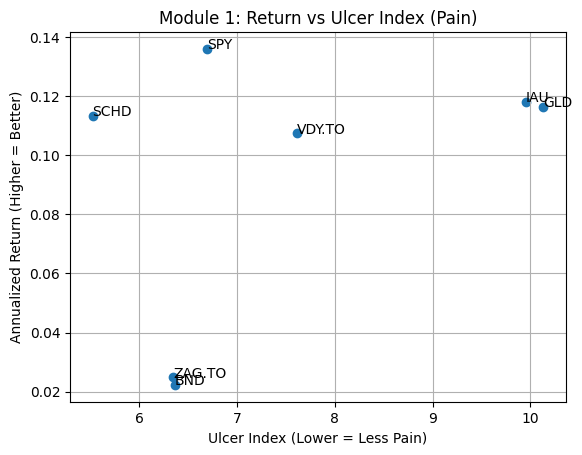

In [18]:
plt.figure()
x = metrics_df["Ulcer Index"]
y = metrics_df["Annualized Return"]

plt.scatter(x, y)

for etf in metrics_df.index:
    plt.text(x.loc[etf], y.loc[etf], etf)

plt.title("Module 1: Return vs Ulcer Index (Pain)")
plt.xlabel("Ulcer Index (Lower = Less Pain)")
plt.ylabel("Annualized Return (Higher = Better)")
plt.grid(True)
plt.show()

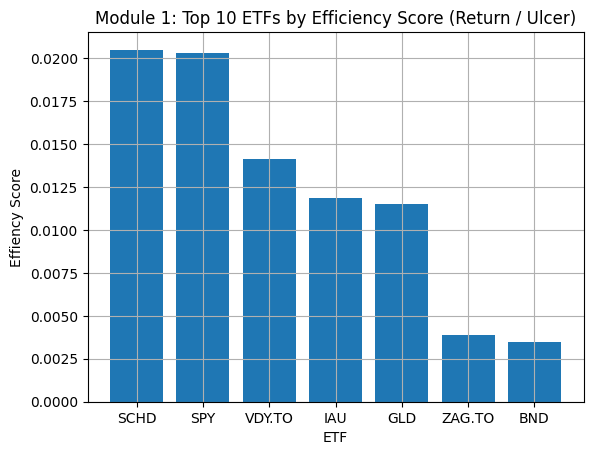

In [19]:
top10 = metrics_df.sort_values("Efficiency Score", ascending=False).head(10)

plt.figure()
plt.bar(top10.index, top10["Efficiency Score"])
plt.title("Module 1: Top 10 ETFs by Efficiency Score (Return / Ulcer)")
plt.xlabel("ETF")
plt.ylabel("Effiency Score")
plt.grid(True)
plt.show()

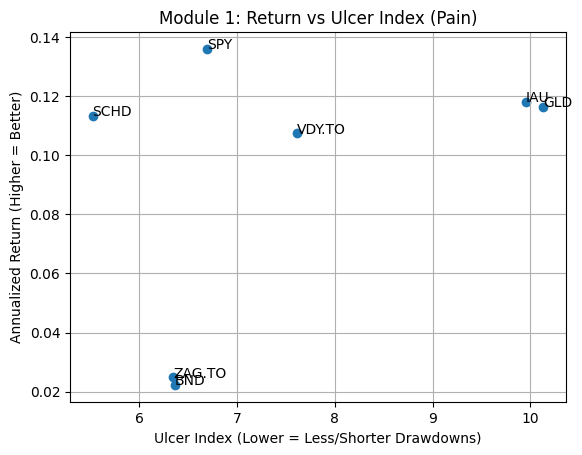

In [20]:
plt.figure()
x = metrics_df["Ulcer Index"]
y = metrics_df["Annualized Return"]
plt.scatter(x, y)

for etf in metrics_df.index:
    plt.text(x.loc[etf], y.loc[etf], etf)

plt.title("Module 1: Return vs Ulcer Index (Pain)")
plt.xlabel("Ulcer Index (Lower = Less/Shorter Drawdowns)")
plt.ylabel("Annualized Return (Higher = Better)")
plt.grid(True)
plt.show()


- Left = less pain, up = more reward
- Best ETFs sit upper left
- thats why return/ulcer is a clean effiency score

The Story:
- SPY (Top Right): Makes the most money, but sits far to the right. It is "High Stress."
- SCHD (Top Left-ish): This is your Winner. It is nearly as high up as SPY (good return) but significantly to the left (less pain). It is the "Efficient" choice.
- BND (Bottom): Low return and, surprisingly, historically high pain recently. It is currently the "Worst of both worlds."

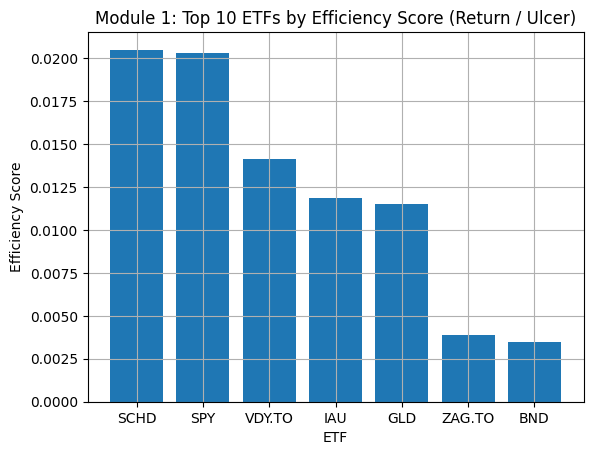

In [21]:
top10 = metrics_df.sort_values("Efficiency Score", ascending=False).head(10)

plt.figure()
plt.bar(top10.index, top10["Efficiency Score"])
plt.title("Module 1: Top 10 ETFs by Efficiency Score (Return / Ulcer)")
plt.xlabel("ETF")
plt.ylabel("Efficiency Score")
plt.grid(True)
plt.show()

divide "Return" by "Pain." A taller bar means you are getting a better deal.

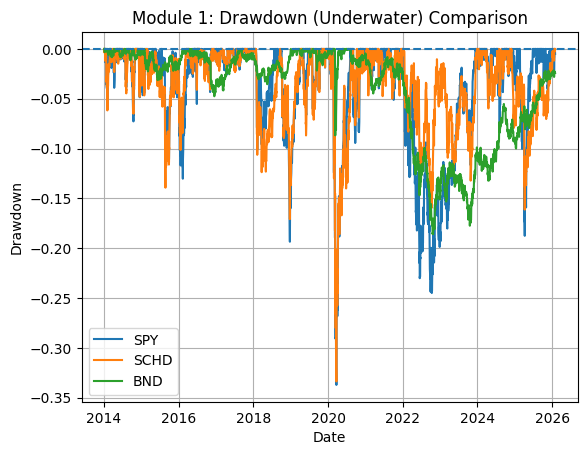

In [22]:
def drawdown_series(r):
    eq = (1 + r.fillna(0)).cumprod()
    peak = eq.cummax()
    return (eq / peak - 1)

compare = [t for t in ["SPY","SCHD","USMV","QUAL","BND"] if t in returns_wide.columns]

plt.figure()
for t in compare:
    plt.plot(drawdown_series(returns_wide[t]), label=t)

plt.axhline(0, linestyle="--")
plt.title("Module 1: Drawdown (Underwater) Comparison")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()


- Blue Line (SPY): Deep dives. It goes down fast and hard.
- Orange Line (SCHD): Notice that in many crashes, the Orange line doesn't go as deep as the Blue line. It is a "life jacket"—you still get wet, but you don't drown.
- Green Line (BND): Look at the right side (2022-present). It went deep underwater and stayed there. It hasn't recovered. This scares passive investors.

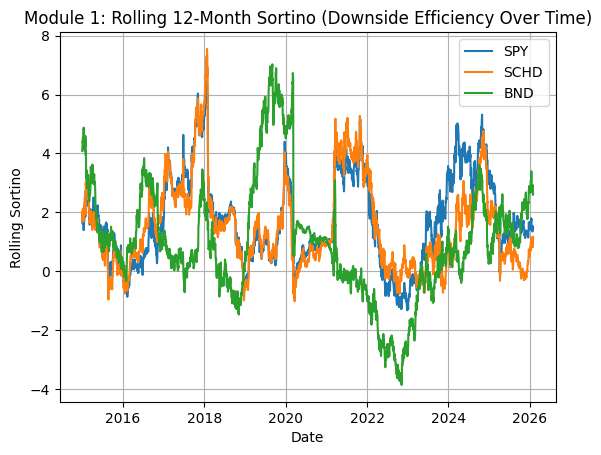

In [23]:
TRADING_DAYS = 252

def rolling_sortino(r, window=252, mar_annual=0.0):
    mar_daily = (1 + mar_annual)**(1/TRADING_DAYS) - 1
    out = []
    idx = r.dropna().index
    r = r.dropna()
    for i in range(window, len(r)+1):
        chunk = r.iloc[i-window:i]
        downside = np.minimum(chunk - mar_daily, 0.0)
        downside_dev = downside.std(ddof=0) * np.sqrt(TRADING_DAYS)
        ann_excess = (chunk.mean() - mar_daily) * TRADING_DAYS
        out.append(ann_excess / downside_dev if downside_dev != 0 else np.nan)
    return pd.Series(out, index=idx[window-1:])

winners = [t for t in ["SPY","SCHD","BND"] if t in returns_wide.columns]

plt.figure()
for t in winners:
    rs = rolling_sortino(returns_wide[t], window=252)
    plt.plot(rs, label=t)

plt.title("Module 1: Rolling 12-Month Sortino (Downside Efficiency Over Time)")
plt.xlabel("Date")
plt.ylabel("Rolling Sortino")
plt.legend()
plt.grid(True)
plt.show()


- this shows if the etf stay efficient consistenly, not only on average

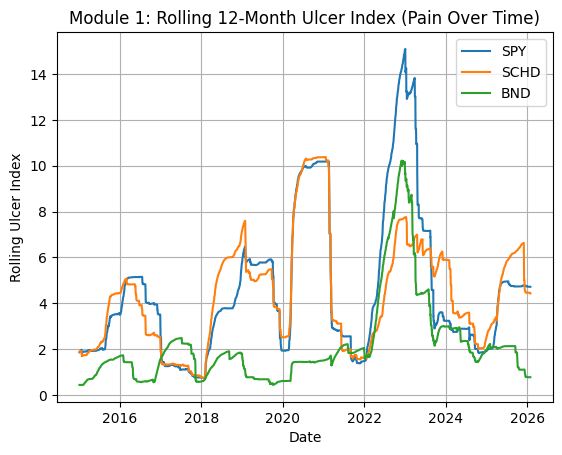

In [24]:
def rolling_ulcer(r, window=252):
    r = r.dropna()
    out = []
    idx = r.index
    for i in range(window, len(r)+1):
        chunk = r.iloc[i-window:i]
        eq = (1 + chunk).cumprod()
        peak = eq.cummax()
        dd_pct = (eq / peak - 1) * 100.0
        out.append(np.sqrt(np.mean(dd_pct**2)))
    return pd.Series(out, index=idx[window-1:])

plt.figure()
for t in [x for x in ["SPY","SCHD","USMV","BND"] if x in returns_wide.columns]:
    ru = rolling_ulcer(returns_wide[t], window=252)
    plt.plot(ru, label=t)

plt.title("Module 1: Rolling 12-Month Ulcer Index (Pain Over Time)")
plt.xlabel("Date")
plt.ylabel("Rolling Ulcer Index")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
ru_spy = rolling_ulcer(returns_wide["SPY"], window=252)
print("First rolling date:", ru_spy.index.min())
print("Original data start:", returns_wide.index.min())

First rolling date: 2015-01-02 00:00:00
Original data start: 2014-01-03 00:00:00
